In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ProteInfer Class Activation Mapping (CAM)




## Initial setup (code/data download)

In [ ]:
!git clone https://github.com/google-research/proteinfer 

%cd proteinfer
!pip3 install -qr  requirements.txt

import pandas as pd
import tensorflow
import inference
import parenthood_lib
import baseline_utils,subprocess
import shlex
import tqdm 
import sklearn
import numpy as np
import utils
import colab_evaluation
import plotly.express as px
import seaborn as sns

from plotnine import ggplot, geom_point, geom_point, geom_line, aes, stat_smooth, facet_wrap, xlim,coord_cartesian,theme_bw,labs,ggsave


Cloning into 'proteinfer'...
remote: Enumerating objects: 491, done.
remote: Counting objects: 100% (214/214), done.
remote: Compressing objects: 100% (177/177), done.
remote: Total 491 (delta 96), reused 49 (delta 20), pack-reused 277
Receiving objects: 100% (491/491), 11.55 MiB | 8.51 MiB/s, done.
Resolving deltas: 100% (235/235), done.
/content/proteinfer
     |████████████████████████████████| 99 kB 3.4 MB/s 
     |████████████████████████████████| 2.3 MB 30.7 MB/s 
     |████████████████████████████████| 10.8 MB 26.8 MB/s 
     |████████████████████████████████| 2.8 MB 29.6 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 89 kB 7.5 MB/s 
     |████████████████████████████████| 56 kB 4.8 MB/s 
     |████████████████████████████████| 17.3 MB 48 kB/s 
     |████████████████████████████████| 10.5 MB 34.2 MB/s 
     |████████████████████████████████| 107 kB 50.4 MB/s 
     |████

In [ ]:
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/models/zipped_models/noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz
!tar xzf noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140.tar.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/colab_support/parenthood.json.gz
!wget -qN https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/blast_baseline/fasta_files/SWISSPROT_RANDOM_EC/eval_test.fasta



In [ ]:
def get_ec_num_mapping():
  tree = ET.parse('enzyme-data.xml')
  root = tree.getroot()
  rows = root[0][3].findall('row')
  rows = root.findall(".//field[@name='accepted_name']..")
  ec_nums = {}
  for row in rows:
      ec_num = row.find(".//*[@name='ec_num']").text
      name = row.find(".//*[@name='accepted_name']").text
      try:
        ec_nums[ec_num]=name
      except TypeError:
        continue
  return ec_nums

def download_dataset():
  total = 13
  file_shard_names = ['https://storage.googleapis.com/brain-genomics-public/research/proteins/proteinfer/datasets/swissprot/random/test-{:05d}-of-{:05d}.tfrecord'.format(i,total) for i in range(total)]

  for shard_name in tqdm.tqdm(file_shard_names, position=0,desc="Downloading"):
    subprocess.check_output(shlex.split(f'wget {shard_name}'))
  return 

In [ ]:

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
!wget -qN https://www.enzyme-database.org/downloads/enzyme-data.xml.gz
!gunzip -f enzyme-data.xml.gz


import xml.etree.ElementTree as ET


ec_nums = get_ec_num_mapping()
download_dataset()

Downloading: 100%|██████████| 13/13 [00:04<00:00,  2.02it/s]


##Read in the test dataset

In [ ]:
import protein_dataset
import tqdm
import numpy as np
sequence_iterator = protein_dataset.yield_examples("./test*.tfrecord")
sequences = []
labels = []
ids = []
for example in tqdm.tqdm(sequence_iterator):
  ids.append(example[protein_dataset.SEQUENCE_ID_KEY])
  sequences.append(example[protein_dataset.SEQUENCE_KEY])
  labels.append(example[protein_dataset.LABEL_KEY])

# If we want to optimise for inference speed we should sort the dataset by
# sequence length:
seq_lengths = [len(x) for x in sequences]
indices = np.argsort(-np.array(seq_lengths)).tolist()

ids = [ids[indices[x]] for x in range(len(indices))]
sequences = [sequences[indices[x]] for x in range(len(indices))]
labels = [set(labels[indices[x]]) for x in range(len(indices))]

0it [00:00, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0909 12:36:54.501479 140666907211648 deprecation.py:323] From /content/proteinfer/protein_dataset.py:290: DatasetV1.make_one_shot_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
54285it [00:27, 1953.67it/s]


## Load the saved model

In [ ]:
inferrer = inference.Inferrer(
    'noxpnd_cnn_swissprot_ec_random_swiss-cnn_for_swissprot_ec_random-13685140',use_tqdm= True, batch_size=32,activation_type="representation"
)

label_vocab = list(inferrer.get_variable('label_vocab:0').astype(str))
label_normalizer = parenthood_lib.get_applicable_label_dict(
    'parenthood.json.gz')


kernel = inferrer.get_variable("logits/kernel/read:0")



W0909 12:37:24.753336 140666907211648 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow_core/python/ops/ragged/ragged_tensor.py:1586: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
def get_multi_full_ec(labels, desired_number=3):
  subset = [x for x in labels if x.startswith(b"EC:")]
  subset = [x for x in subset if b'-' not in x]
  if len(subset)==desired_number:
    return subset
  else:
    return []

In [ ]:
def moving_average(a, n=3) :
    new = np.zeros_like(a)
    length_dim = a.shape[0]
    for i in range(length_dim):
      new[i,:]=np.mean(a[np.maximum(i-n,0):np.minimum(i+n,length_dim),:],axis=0)
    return new


In [ ]:
from matplotlib import colors as clr
from matplotlib import pyplot as plt
palette = clr.LinearSegmentedColormap.from_list('custom blue', ['#FFFFFF','#EEEEEE','#00EE00'], N=256)

In [ ]:
items_that_satisfy_criteria = []
for i in range(len(sequences)):
  new_lab = get_multi_full_ec(labels[i],desired_number=2)
  new_seq = sequences[i]
  new_id = ids[i]
  if len(new_lab)>0:
    items_that_satisfy_criteria.append({'labels':new_lab, 'sequence':new_seq, 'id':new_id})


## Perform inference

Annotating batches of sequences: 100%|██████████| 1/1 [00:01<00:00,  1.06s/it]


Q54QE4


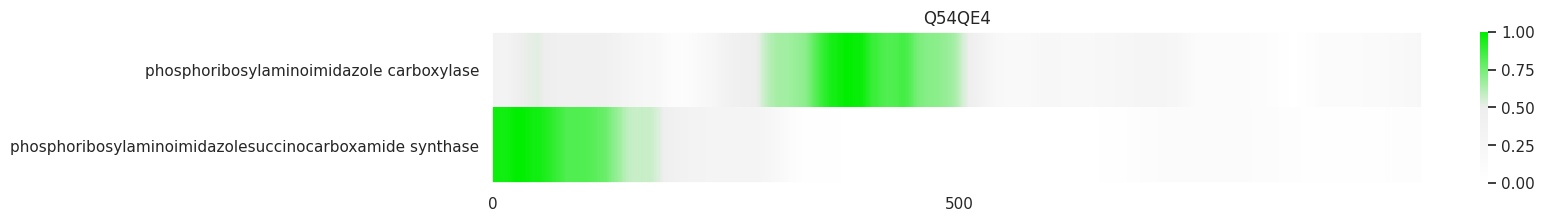

Annotating batches of sequences: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


Q9PLG1


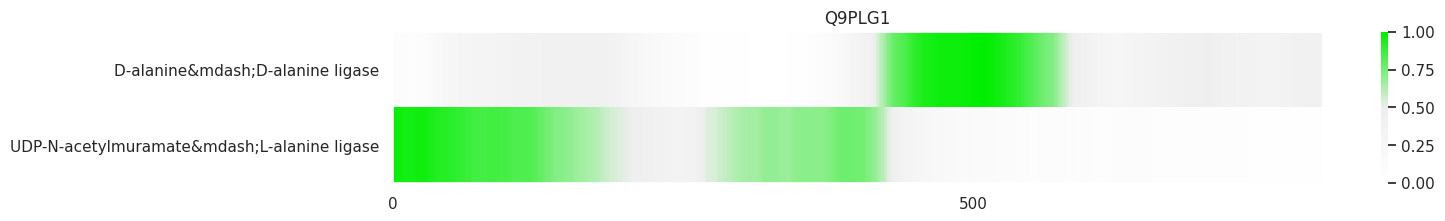

Annotating batches of sequences: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


P54889


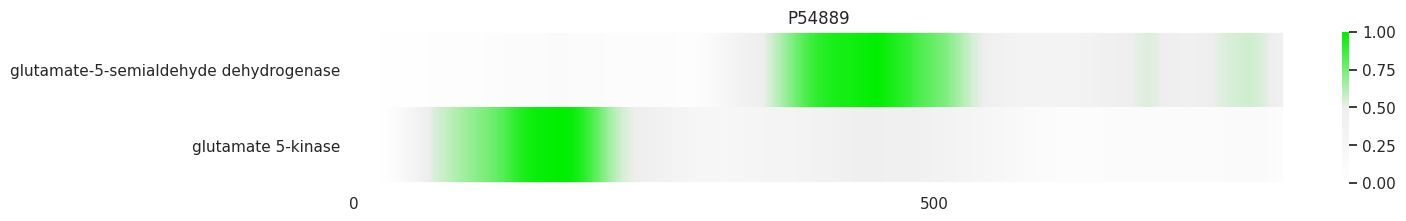

Annotating batches of sequences: 100%|██████████| 1/1 [00:00<00:00,  1.21it/s]


O94632


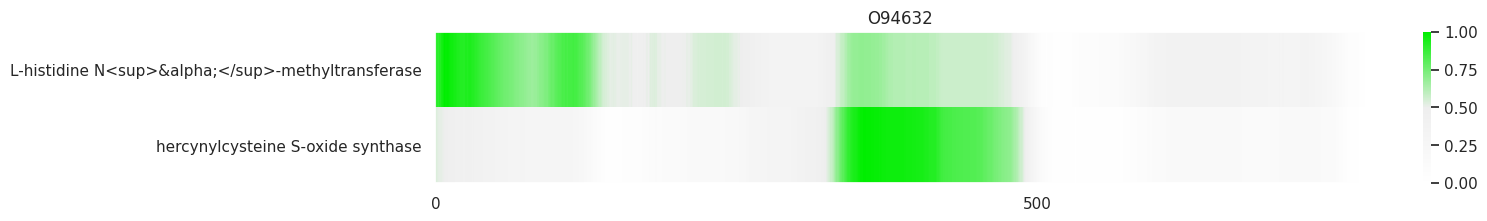

Annotating batches of sequences: 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]


P19835


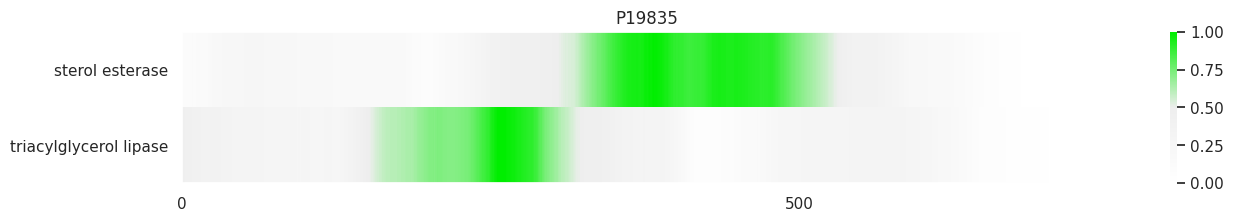

Annotating batches of sequences: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]


Q3MEJ8


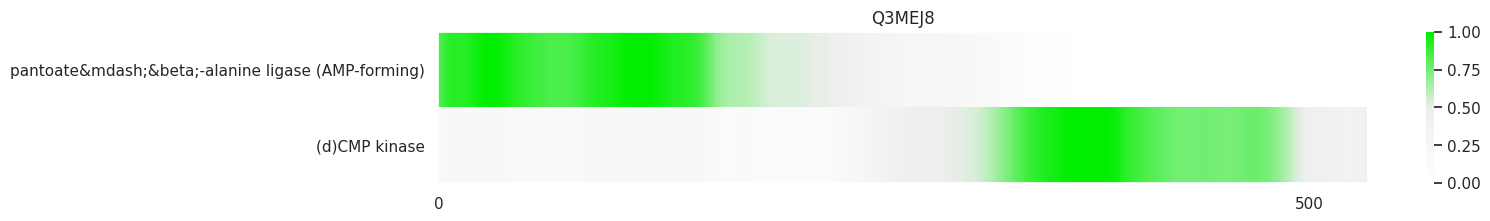

In [ ]:
counter = 0

sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (15, 35)})

one_by_one = False
ids = ['Q4LB35', 'Q54QE4', 'P54889', 'Q9PLG1', 'O94632', 'P19835', 'Q3MEJ8']
if True:
    sns.set(rc={'figure.figsize': (15, 2)})

for item in items_that_satisfy_criteria:
    if item['id'].decode() in ids or one_by_one:

        the_labels = item['labels']
        representation = inferrer.get_activations(
            [item['sequence'].decode("utf-8")])
        label_ids = [label_vocab.index(x.decode('utf-8')) for x in the_labels]
        contributions = np.matmul(representation.squeeze(),
                                  kernel)[:, label_ids]

        sum_contributions = contributions.sum(axis=1)
        contributions = np.maximum(contributions, 0)
        contributions = moving_average(contributions, 80)
        contributions = contributions / contributions.max(axis=0,
                                                          keepdims=True)

        df = pd.DataFrame(contributions.T)
        try:
            df.index = [
                ec_nums[x.decode().replace("EC:", "")].replace(
                    "<em>",
                    "").replace("</em>",
                                "").replace("<small>",
                                            "").replace("</small>", "")
                for x in the_labels
            ]
        except KeyError:
            continue
        print(item['id'].decode())
        ax = None
        if False:
            ax = axes[counter]
        try:
            g = sns.heatmap(df, cmap=palette, xticklabels=500, ax=ax, vmin=0)
            counter += 1
            g.set_title(item['id'].decode())
            for _, spine in g.spines.items():
                spine.set_visible(True)
            plt.yticks(rotation=0)
            plt.xticks(rotation=0)
            plt.subplots_adjust(hspace=0.7)
        except ValueError:
            continue

        if True:
            plt.show()

plt.show()
